In [9]:
import os
import torch
from torch import nn
import numpy as np
import random
from dataset import ModelnetDataset
from pathlib import Path
from torch.utils.data import DataLoader


from util import setup_seed, train, test, train_HHN, test_HHN, train_one4one, transform_angles, count_parameters, save_checkpoint
from model import One4All, HyperNetwork
from render import PointcloudRender
from tqdm import tqdm

from pytorch3d.structures import Meshes, Pointclouds
from pytorch3d.vis.plotly_vis import plot_scene
import plotly.graph_objects as go
import time
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import warnings
import glob

In [10]:
setup_seed(666)
device_for_dataset = "cuda:0" if torch.cuda.is_available() else "cpu"

In [11]:

path = Path("./data/ModelNet10")
test_ds = ModelnetDataset(path, folder="test", device=device_for_dataset) # Just put dataset in mem or GPU
classes = {i: cat for cat, i in test_ds.classes.items()}

print('Test dataset size: ', len(test_ds))
print('Number of classes: ', len(test_ds.classes))

Preocessing test data in_mem = True and infor: Default infor


Prepare test dataset categories: 100%|██████████| 10/10 [00:05<00:00,  1.70it/s]

Test dataset size:  908
Number of classes:  10


In [12]:
from collections import Counter
# print(dict(Counter(sample['category'] for sample in train_ds.files)))

print(dict(Counter(sample['category'] for sample in test_ds.files)))


{'bathtub': 50, 'bed': 100, 'chair': 100, 'desk': 86, 'dresser': 86, 'monitor': 100, 'night_stand': 86, 'sofa': 100, 'table': 100, 'toilet': 100}


In [13]:
batch_size = 32
test_loader = DataLoader(dataset=test_ds, batch_size=batch_size, shuffle=True)
gpu_computation = device_for_dataset
pr = PointcloudRender(              
                 img_size=128,
                 radius=0.0045,
                 points_per_pixel=40,
                 num_points = 4096)
loss_fn = nn.CrossEntropyLoss()


In [7]:
def evaluate_HHN(model, accuracy_file_path, device):
    torch.cuda.empty_cache()
    acc = [] #[0.0]
    step = 30
    with tqdm(range(-180, 181, step), position=0) as t:
        for x in t:
            for y in tqdm(range(-180, 181, step), disable=True):
                for z in tqdm(range(-180, 181, step), disable=True):
                    t.set_description(f'Test HHN-D')
                    
                    angles = torch.tensor([x,y,z])/180*torch.pi
                    t1 = time.time()
                    test_acc, _ = test_HHN(test_loader, model, loss_fn, pr, device=device, angles=angles, verbose=False)
                    t2 = time.time()
                    print(f'runtime: {t2-t1:>.4}s')
                    acc.append(test_acc)
                    t.set_postfix(Angles = [x,y,z],accuracy=test_acc) 
    acc = np.array(acc)

    np.save(accuracy_file_path, acc)
    print(f'average acc : {acc.mean()}')

### Evaluate HHN

In [14]:
checkpoints_path = {
    3: './weight/LeNet5/E5999-bs256_lr0.006_6k_D_3-HHNcheckpoint.pth.tar',
    6: './weight/LeNet5/E5999-bs256_lr0.006_6k_D_6-HHNcheckpoint.pth.tar',
    16: './weight/LeNet5/E5999-bs256_lr0.006_6k_D_16-HHNcheckpoint.pth.tar',
    32: './weight/LeNet5/E5999-bs256_lr0.006_6k_D_32-HHNcheckpoint.pth.tar',    
    1: './weight/LeNet5/E5999-bs256_lr0.006_6k_D_1-HHNcheckpoint.pth.tar',
    2: './weight/LeNet5/E5999-bs256_lr0.006_6k_D_2-HHNcheckpoint.pth.tar',
    5: './weight/LeNet5/E5999-bs256_lr0.006_6k_D_5-HHNcheckpoint.pth.tar',
    8: './weight/LeNet5/E5999-bs256_lr0.006_6k_D_8-HHNcheckpoint.pth.tar',
    
} 

In [ ]:
for d in [1, 2, 3, 5, 6, 8, 16, 32]:
    model = HyperNetwork(dimensions=d).to(gpu_computation)
    resume = checkpoints_path[d]

    checkpoint = torch.load(resume, map_location=gpu_computation)
    model.load_state_dict(checkpoint['state_dict'])

    evaluate_HHN(model=model, accuracy_file_path=f'./accuracy_result_npy/LeNet5/HHN_acc_d_{d}.npy', device=gpu_computation)


In [ ]:
acc_HHN_d1 = np.load('./accuracy_result_npy/LeNet5/HHN_acc_d_1.npy').mean()
print(acc_HHN_d1)

In [ ]:
acc_HHN_d2 = np.load('./accuracy_result_npy/LeNet5/HHN_acc_d_2.npy').mean()
print(acc_HHN_d2)

In [ ]:
acc_HHN_d3 = np.load('./accuracy_result_npy/LeNet5/HHN_acc_d_3.npy').mean()
print(acc_HHN_d3)

In [ ]:
acc_HHN_d5 = np.load('./accuracy_result_npy/LeNet5/HHN_acc_d_5.npy').mean()
print(acc_HHN_d5)

In [ ]:
acc_HHN_d6 = np.load('./accuracy_result_npy/LeNet5/HHN_acc_d_6.npy').mean()
print(acc_HHN_d6)

In [ ]:
acc_HHN_d8 = np.load('./accuracy_result_npy/LeNet5/HHN_acc_d_8.npy').mean()
print(acc_HHN_d8)

In [ ]:
acc_HHN_d16 = np.load('./accuracy_result_npy/LeNet5/HHN_acc_d_16.npy').mean()
print(acc_HHN_d16)

In [ ]:
acc_HHN_d32 = np.load('./accuracy_result_npy/LeNet5/HHN_acc_d_32.npy').mean()
print(acc_HHN_d32)

## Model parameter size

In [ ]:
for d in [1, 2, 3, 5, 6, 8, 16, 32]:
    model = HyperNetwork(dimensions=d)
    # resume = checkpoints_path[d]

    # checkpoint = torch.load(resume, map_location=gpu_computation)
    # model.load_state_dict(checkpoint['state_dict'])
    num_parameter_hyper_stack = count_parameters(model.hyper_stack)
    num_parameter_total = count_parameters(model)
    num_parameter_inference = num_parameter_total - num_parameter_hyper_stack
    print(f'D = {d} num of hyper-net parameters {num_parameter_hyper_stack}. num of inference-net parameters {num_parameter_inference}. num of total parameters {num_parameter_total}')


### violin chart for 3D HHN acc


#### add selected-degrees evluation results to violin chart


In [24]:
# checkpoints_path_one4one = glob.glob("./weight/LeNet5/*one4onecheckpoint*.tar"

In [7]:
import glob
import re

In [8]:
checkpoints_path_one4one = glob.glob("./weight/LeNet5/*one4onecheckpoint*.tar")


degrees = []
for p in checkpoints_path_one4one:
    xyz = re.findall('[-+]?\d+', p.replace("--", "+"))[2:5]
    xyz = [-int(s) for s in xyz]
    _x, _y, _z = xyz
    degrees.append(xyz)

In [47]:
# acc_result_

In [ ]:


num_test_degrees = 4


checkpoints_path_one4one = glob.glob("./weight/LeNet5/*one4onecheckpoint*.tar")


x_pos = []
y_pos = []
degrees = []
for p in checkpoints_path_one4one:
    xyz = re.findall('[-+]?\d+', p.replace("--", "+"))[2:5]
    xyz = [-int(s) for s in xyz]
    _x, _y, _z = xyz
    degrees.append(xyz)
    # print(p)
    # print(xyz)
    angles = torch.tensor([_x,_y,_z])/180*torch.pi

    # one4all
    for i in [1]:
        model = One4All() 
        model = model.to(gpu_computation)
        resume = './weight/LeNet5/E5950-bs256_lr0.002_6k-one4allcheckpoint.pth.tar'
        checkpoint = torch.load(resume, map_location= gpu_computation)
        model.load_state_dict(checkpoint['state_dict'])
        test_acc, _ = test(test_loader, model, loss_fn, pr, device=gpu_computation, angles=angles, verbose=False)

    _one4all_acc = test_acc
    x_pos.append(0)
    y_pos.append(_one4all_acc)

    #HHN
    _hhn_acc_list = []
    for d in [1, 2, 3, 5, 6, 8, 16, 32]:
        model = HyperNetwork(dimensions=d).to(gpu_computation)
        resume = checkpoints_path[d]

        checkpoint = torch.load(resume, map_location=gpu_computation)
        model.load_state_dict(checkpoint['state_dict'])
        
        torch.cuda.empty_cache()
        test_acc, _ = test_HHN(test_loader, model, loss_fn, pr, device=gpu_computation, angles=angles, verbose=False)
        _hhn_acc_list.append(test_acc)
        
        x_pos.append(d)
        y_pos.append(test_acc)

    # one4one
    for i in [1]:
        model = One4All() 
        model = model.to(gpu_computation)
        resume = p
        checkpoint = torch.load(resume, map_location= gpu_computation)
        model.load_state_dict(checkpoint['state_dict'])
        test_acc, _ = test(test_loader, model, loss_fn, pr, device=gpu_computation, angles=angles, verbose=False)

    _one4one_acc = test_acc

    x_pos.append(d+2)
    y_pos.append(_one4one_acc)

In [20]:
acc_result_ = np.array(list(zip(x_pos, y_pos)))

In [21]:
x_pos_, y_pos_ = acc_result_[:,0], acc_result_[:,1]

In [17]:
import plotly.express as px

# define color set
pre_defined_colors = px.colors.qualitative.Light24 + px.colors.qualitative.Dark24

<Figure size 3000x2000 with 0 Axes>

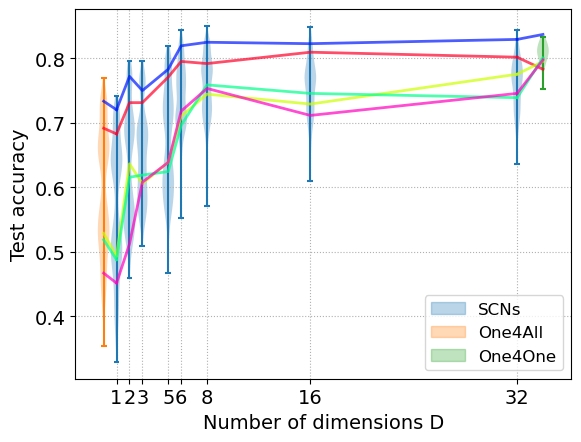

In [29]:
dsm = [1,2,3,5,6,8,16,32]

vis_factor = 1 # increase the width of the image

acc_HHN = []
for i in dsm:
    acc_HHN_di = np.load(f'./accuracy_result_npy/LeNet5/HHN_acc_d_{i}.npy')[1:]
    acc_HHN.append(acc_HHN_di)

acc_one4all = np.load('./accuracy_result_npy/LeNet5/one4all_acc.npy')

acc_one4one = np.load('./accuracy_result_npy/LeNet5/one4one_acc.npy')

# helper function
labels = []
def add_label(violin, label):
    color = violin["bodies"][0].get_facecolor().flatten()
    labels.append((mpatches.Patch(color=color), label))
# fixed_shifts = [(-8, -8), (-8, 8), (8, -8), (8, 8), (0, 0)]

# Plot D vs acc, with One4All, One4One
fig = plt.figure(figsize=(30,20))
fig.tight_layout()
fig, ax = plt.subplots()

add_label(ax.violinplot(acc_HHN, [1,2,3,5,6,8,16,32], widths=0.9), 'SCNs')

add_label(ax.violinplot(acc_one4all, [0], widths=0.9), 'One4All')
_colors = plt.cm.gist_rainbow(np.linspace(0, 1, 5))#px.colors.qualitative.Plotly
for i in range(5):
    plt.plot(x_pos_[10*i:10*i+2], y_pos_[10*i:10*i+2], "-", color=_colors[i], alpha=0.7, linewidth=2)
    plt.plot(x_pos_[10*i+1:10*i+9], y_pos_[10*i+1:10*i+9], "-", color=_colors[i], alpha=0.7, linewidth=2)
    plt.plot(x_pos_[10*i+8:10*(i+1)], y_pos_[10*i+8:10*(i+1)], "-", color=_colors[i], alpha=0.7, linewidth=2)

    # plt.plot(x_pos_[10*i:10*(i+1)], y_pos_[10*i:10*(i+1)], "-", color=pre_defined_colors[i], alpha=0.7, linewidth=0.5)

add_label(ax.violinplot(acc_one4one, [dsm[-1] + 2], widths=0.9), "One4One")

plt.legend(*zip(*labels), loc='lower right', prop={'size': 12})
plt.xlabel('Number of dimensions D', fontdict={'size':14})
plt.ylabel('Test accuracy', fontdict={'size':14})


# x_sticks_labels = [r"one4all", r'$SCN_{D=1}$', r'$SCN_{D=2}$', r'$SCN_{D=3}$',r'$SCN_{D=5}$',r'$SCN_{D=6}$',r'$SCN_{D=8}$',r'$SCN_{D=16}$',r'$SCN_{D=32}$', r"one4one"]
# plt.xticks(x_sticks, rotation=45)

ax.set_xticks(dsm)
# ax.set_xticks([d*vis_factor for d in dsm])
# ax.set_xticklabels(x_sticks_labels, rotation=90)

ax.tick_params(axis='x', which='major', labelsize=14)
ax.tick_params(axis='y', which='major', labelsize=14)
ax.grid(True, linestyle=':')
# plt.tight_layout()



# # change x internal size
# plt.gca().margins(x=0)
# plt.gcf().canvas.draw()
# tl = plt.gca().get_xticklabels()
# # maxsize = max([t.get_window_extent().width for t in tl])
# maxsize = 30
# m = 0.2  # inch margin
# s = maxsize / plt.gcf().dpi * 50 + 2 * m
# margin = m / plt.gcf().get_size_inches()[0]

# plt.gcf().subplots_adjust(left=margin, right=1. - margin)
# plt.gcf().set_size_inches(s, plt.gcf().get_size_inches()[1])

plt.savefig(f'plots/accuracy_result_chart.jpg', dpi=250)

<Figure size 3000x3000 with 0 Axes>

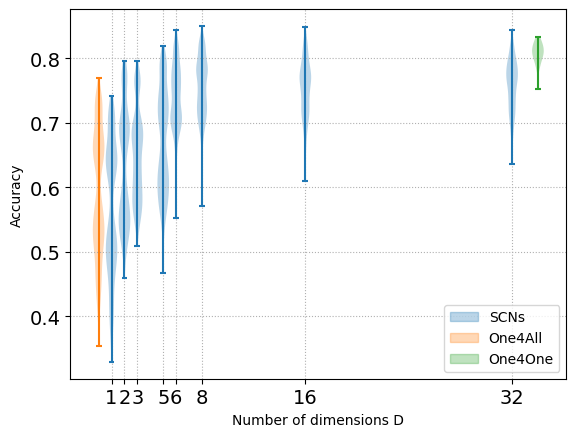

In [278]:
dsm = [1,2,3,5,6,8,16,32]

acc_HHN = []
for i in dsm:
    acc_HHN_di = np.load(f'./accuracy_result_npy/LeNet5/HHN_acc_d_{i}.npy')[1:]
    acc_HHN.append(acc_HHN_di)
    # print(acc_HHN_di.mean())

acc_one4all = np.load('./accuracy_result_npy/LeNet5/one4all_acc.npy')
# print(acc_one4all.mean())

acc_one4one = np.load('./accuracy_result_npy/LeNet5/one4one_acc.npy')
# print(acc_one4one.mean())


# helper function
labels = []
def add_label(violin, label):
    color = violin["bodies"][0].get_facecolor().flatten()
    labels.append((mpatches.Patch(color=color), label))
fixed_shifts = [(-8, -8), (-8, 8), (8, -8), (8, 8), (0, 0)]

# Plot D vs acc, with One4All, One4One
fig = plt.figure(figsize=(30,30))
fig.tight_layout()
fig, ax = plt.subplots()

add_label(ax.violinplot(acc_HHN, [1,2,3,5,6,8,16,32], widths=0.9), 'SCNs')

add_label(ax.violinplot(acc_one4all, [0], widths=0.9), 'One4All')

add_label(ax.violinplot(acc_one4one, [dsm[-1] + 2], widths=0.9), "One4One")

plt.legend(*zip(*labels), loc='lower right', prop={'size': 10})
plt.xlabel('Number of dimensions D')
plt.ylabel('Accuracy')
plt.xticks(dsm)
ax.tick_params(axis='x', which='major', labelsize=14)
ax.tick_params(axis='y', which='major', labelsize=14)
ax.grid(True, linestyle=':')

plt.savefig(f'plots/accuracy_result_violin_chart.jpg', dpi=100)

In [287]:
# define the relation between fixed angle and showing angles as a dictionary
show_and_fix_angles = {
    'x':[1,2],
    'y':[0,2],
    'z':[0,1]
}

fix_angle_text = {
    'x': r'$\alpha_1$',
    'y': r'$\alpha_2$',
    'z': r'$\alpha_3$'
}


# This relationship between display_channels and text of legend
legend_alpha_text ={
    0: r'$\alpha_1$',
    1: r'$\alpha_2$',
    2: r'$\alpha_3$',

}

<Figure size 640x480 with 0 Axes>

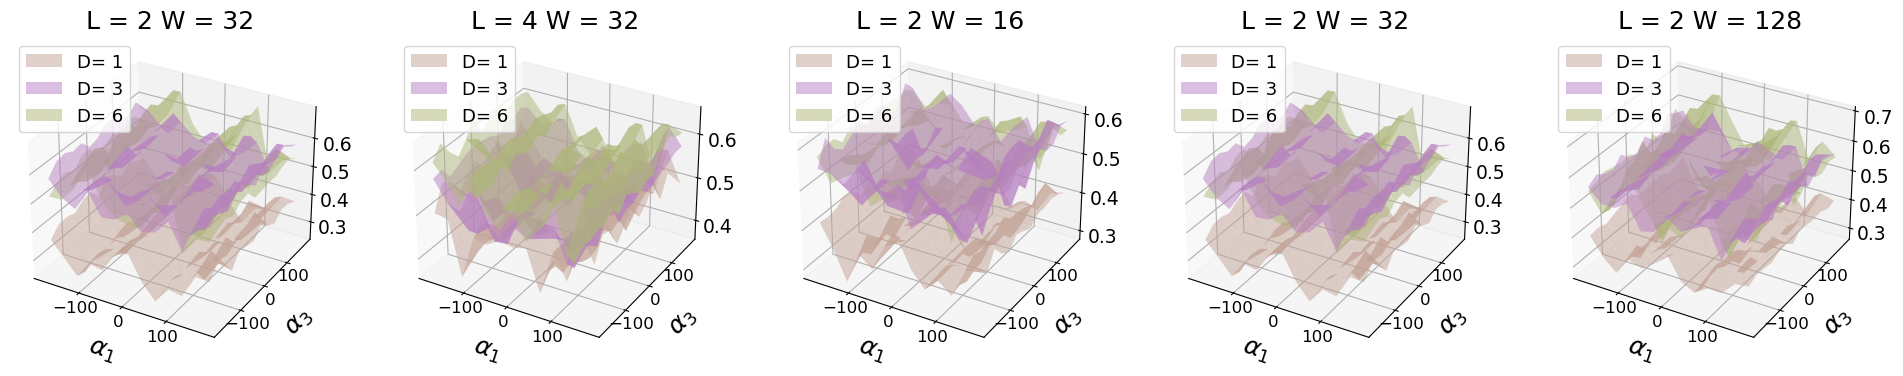

In [338]:
import plotly.express as px

# define color set
pre_defined_colors = px.colors.qualitative.Light24 + px.colors.qualitative.Dark24

fixed_angle = 'y'
display_angles = show_and_fix_angles[fixed_angle]

evaluation_dimensions = [1,3,6]#[1, 2, 3, 5, 6, 8]
fig = plt.figure()
fig.tight_layout()
fig, ax = plt.subplots(1, int(len(l_w)), subplot_kw={"projection": "3d"},figsize=(24,12))

filename=f"plots/acc_distribution_alpha{''.join([str(a+1) for a in display_angles]  )}.jpg"

def reconstrut_acc_with_angles(acc_):
    acc_with_angles = []
    step = 30
    i = 0
    for x in range(-180, 181, step):
        for y in range(-180, 181, step):
            for z in range(-180, 181, step):

                if fixed_angle.lower() == "x":
                    if x==-180:
                        acc_with_angles.append([acc_[i], x, y, z])
                elif fixed_angle.lower() == "y":
                    if y==-180:
                        acc_with_angles.append([acc_[i], x, y, z])
                elif fixed_angle.lower() == "z":
                    if z==-180:
                        acc_with_angles.append([acc_[i], x, y, z])
                
                i+=1
    return np.array(acc_with_angles)

for i, (l, w) in enumerate(l_w):
    

    for d in evaluation_dimensions:
        acc_HHN_di = np.load(f'./accuracy_result_npy/LeNet5/HHN_Lenet_acc_d_{d}_l_{l}_w_{w}.npy')
        color = pre_defined_colors[d*3] 
        acc_HHN_di_with_angles = reconstrut_acc_with_angles(acc_HHN_di)
        x=acc_HHN_di_with_angles[:, display_angles[0]+1] 
        y=acc_HHN_di_with_angles[:, display_angles[1]+1]
        z=acc_HHN_di_with_angles[:, 0]
        surf = ax[i].plot_trisurf(
            x,y,z,
            alpha=0.5, label=f'D='+f" {d}", color=color,  antialiased=True);

        surf._facecolors2d=surf._facecolors3d # only vaild for matplotlib ~= 3.3.2, invaild for 3.6.2
        surf._edgecolors2d=surf._edgecolors3d # only vaild for matplotlib ~= 3.3.2, invaild for 3.6.2

    ncol_lengend = 1
    ax[i].legend(loc="upper left",prop={'size': 13}, ncol=ncol_lengend)
    # ax[i].set_title(f"L = {l} W = {w} {fix_angle_text[fixed_angle]}=-180", fontdict={'size':18});
    ax[i].set_title(f"l = {l} w = {w}", fontdict={'size':18});

    ax[i].tick_params(axis='x', which='major', labelsize=12, pad=-4)
    ax[i].tick_params(axis='y', which='major', labelsize=12, pad=-4)
    ax[i].tick_params(axis='z', which='major', labelsize=13.5, pad=2)
    ax[i].axes.xaxis.labelpad = 1
    ax[i].axes.yaxis.labelpad = 2
    ax[i].axes.zaxis.labelpad = 2

    ax[i].set_xlabel(legend_alpha_text[display_angles[0]], fontsize=18)
    ax[i].set_ylabel(legend_alpha_text[display_angles[1]], fontsize=18)
    ax[i].zaxis.set_rotate_label(False)
    # ax[i].set_zlabel(f'Test accuracy', fontsize=18, rotation=90)
    ax[i].grid(True, linestyle=':')

plt.savefig(filename, dpi=200,bbox_inches='tight');

In [ ]:
# D=1, 3, 6